# Downward Camera Line Detection

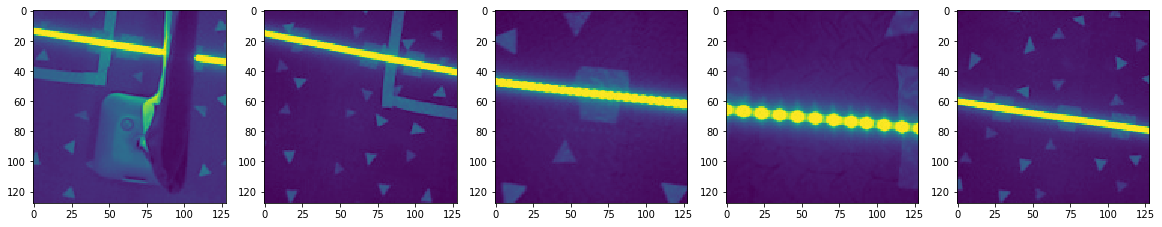

In [72]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from matplotlib.lines import Line2D

lines = glob.glob("./downward/*.jpg")
lines = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in lines]


fig, ax = plt.subplots(ncols=5, nrows=1)
for i in range(len(lines)):    
    ax[i].imshow(lines[i])
    fig.set_size_inches(20,12)

In [86]:
#Some functions from previous notebook
def y(x,m,b):
    return m*x+b
def x(y,m,b):
    return (y-b)/m

def find_inliers(m, b, shape):
    y1 = 0
    x1 = x(y1, m,b)
    y2 = shape[0]
    x2=x(y2,m,b)
    return x1,y1,x2,y2

def calculate_regression(points):
    points = points.astype(float)
    
    xs = points[:, 1]
    
    ys = points[:, 0]
    x_mean = np.mean(xs)
    y_mean = np.mean(ys)
    
    xy_mean = np.mean(xs*ys)

    x_squared_mean = np.mean(xs**2)
    
    m = (x_mean*y_mean-xy_mean)/(x_mean**2-x_squared_mean)
    b = y_mean-m*x_mean
    return (m,b)

## Statistical linear regression

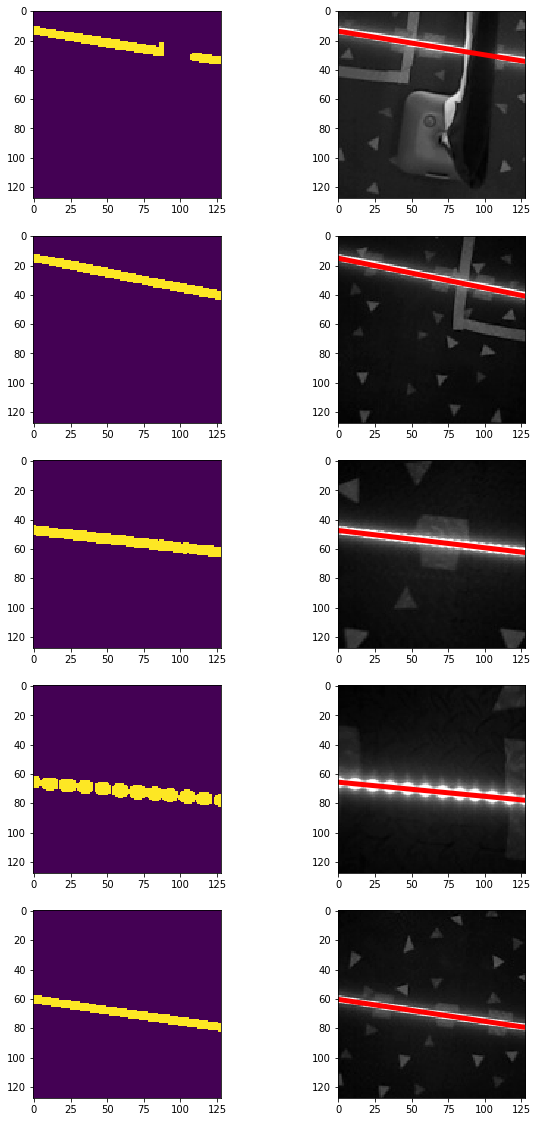

In [90]:
fig,ax =plt.subplots(nrows=len(lines),ncols=2)
for i in range(len(lines)):
    img = np.copy(lines[i])
    kernel=np.ones((3,3),np.uint8)
    result = cv2.inRange(img,245,255)
    
    result = cv2.dilate(result, kernel, iterations=1)
    
    ax[i,0].imshow(result)
    
    points = np.argwhere(result)
    m,b = calculate_regression(points)
    
    x1,y1,x2,y2 = find_inliers(m,b, result.shape)
    regression = Line2D([x1,x2],[y1,y2], color='red', linewidth=5)
    ax[i,1].imshow(lines[i], cmap="gray")
    ax[i,1].add_line(regression)
fig.set_size_inches(10,20)

## OpenCV fitline

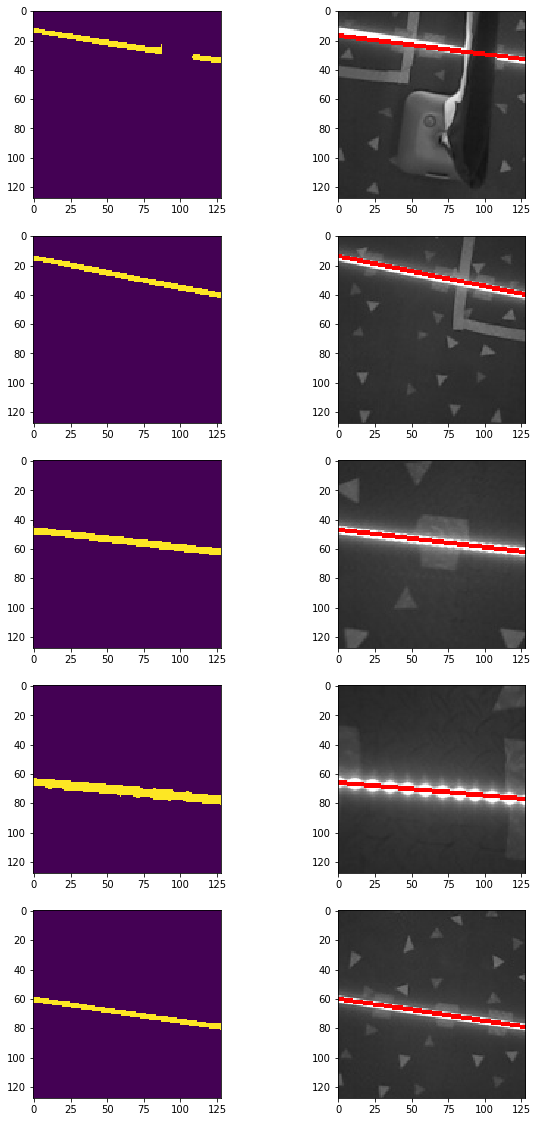

In [91]:
fig,ax =plt.subplots(nrows=len(lines),ncols=2)
for i in range(len(lines)):
    img = np.copy(lines[i])
    kernel=np.ones((3,3),np.uint8)
    result = cv2.inRange(img,245,255)
    
    result = cv2.dilate(result, kernel, iterations=3)
    result = cv2.erode(result, kernel, iterations=3)
    
    ax[i,0].imshow(result)
    
    
    ret,thresh = cv2.threshold(result,245,255,cv2.THRESH_BINARY)
    _, contours, _ = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    rows,cols = img.shape[:2]
    
    [vx,vy,x,y] = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
    lefty = int((-x*vy/vx) + y)
    righty = int(((cols-x)*vy/vx)+y)
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.line(img_color,(cols-1,righty),(0,lefty),(255,0,0),2)
    ax[i,1].imshow(img_color)
fig.set_size_inches(10,20)